<b>

<p>
<center>
<font size="6">
Home Credit Default Risk
</font>
</center>
</p>

<p>
<center>
<font size="4">
--Can you predict how capable each applicant is of repaying a loan?
</font>
</center>
</p>

<p>
<center>
<font size="3">
Team member: Kang Huang, Xinyu Yao, Ya Liu
</font>
</center>
</p>

</b>

# Table of Contents:
### 1. Introduction 
   - 1.1 Problem Description
   - 1.2 Data Description

### 2. Exploratory Data Analysis

### 3. Feature Engineering
   - 3.1 Abstract Features
   - 3.2 Feature Selection

### 4. Model Development
   - 4.1 Data preprocessing
   - 4.2 Hyperparamter Tuning
   - 4.3 Model Selection
   - 4.4 Model Fit and Prediction

### 5. Conclusion and Discussion
   - 5.1 Feature Importance
   - 5.2 Discussion

### 6. Reference 

# 1. Introduction

## 1.1 Problem Description

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're in need of help unlocking the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## 1.2 Data Description

Application_train.csv: the main training data with information about each loan application at Home Credit. Every loan has its own row with the ‘TARGET’ indication 0: the loan was repaid or 1: the loan was not repaid

bureau.csv: all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

bureau_balance.csv: monthly balances of previous credits in Credit Bureau. This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

POS_CASH_balance.csv: monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

credit_card_balance.csv: monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

previous_application.csv: all previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

installments_payments.csv:repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is a) one row for every payment that was made plus b) one row each for missed payment. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

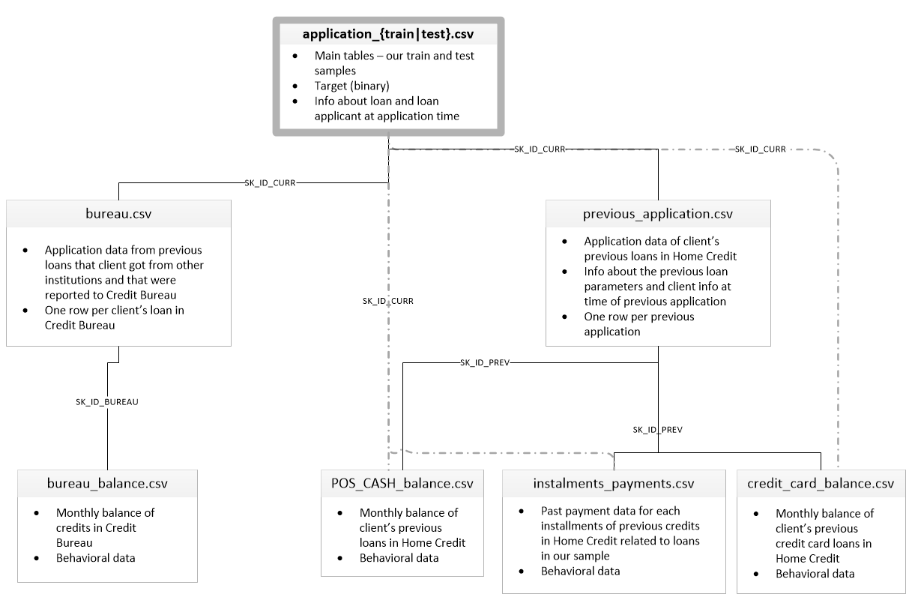

In [9]:
from IPython.display import Image
PATH = "/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/"
Image(filename = PATH + "data_description.png")

# 2. Exploratory Data Analysis

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [18]:
import pandas as pd

# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
print(app_train.head())

# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
print(app_test.head())

Training data shape:  (307511, 122)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0

## Pre-processing

### Check anomalous values

In [19]:
print((app_train['DAYS_BIRTH'] / 365).describe())

count    307511.000000
mean        -43.936973
std          11.956133
min         -69.120548
25%         -53.923288
50%         -43.150685
75%         -34.008219
max         -20.517808
Name: DAYS_BIRTH, dtype: float64


'DAYS_BIRTH' are negative values which does not make sense, so we get their absolute values.

In [20]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

In [5]:
print(app_train['DAYS_EMPLOYED'].describe())

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


'DAYS_EMPLOYED' is How many days before the application the person started current employment. The maximum value 365243 (besides being positive) is about 1000 years.

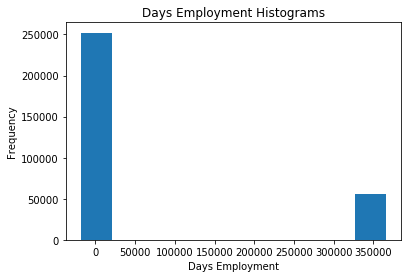

There are 18.01% anomalies in the train data
There are 19.03% anomalies in the test data


In [6]:
plt.hist(app_train['DAYS_EMPLOYED'].values)
plt.title('Days Employment Histograms')
plt.xlabel('Days Employment')
plt.ylabel('Frequency')
plt.show()

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] > 36500
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] > 36500

print('There are %0.2f%% anomalies in the train data' % (100 * app_train["DAYS_EMPLOYED_ANOM"].sum()/len(app_train)))
print('There are %0.2f%% anomalies in the test data' % (100 * app_test["DAYS_EMPLOYED_ANOM"].sum()/len(app_test)))

There're about 20%, so before we replace these anomalous values with nan, we create a new column to set a flag of these originally anomalous values and then we replace these anomalous values with nan. Also we transfer 'DAYS_EMPLOYED' to their absolute values to make it non-negative.

In [21]:
# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])

app_test['DAYS_EMPLOYED'] = abs(app_test['DAYS_EMPLOYED'])
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

We then check the distribution of 'DAYS_EMPLOYED'.

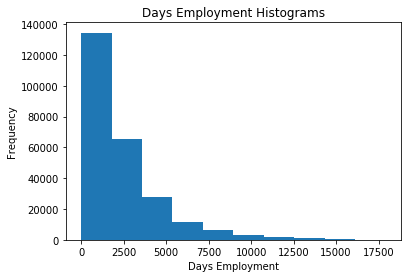

In [22]:
plt.hist(app_train['DAYS_EMPLOYED'].values)
plt.title('Days Employment Histograms')
plt.xlabel('Days Employment')
plt.ylabel('Frequency')
plt.show()

The distribution looks to be much more in line with what we would expect.

## Exploratory Data Analysis (EDA)

### Distribution of target

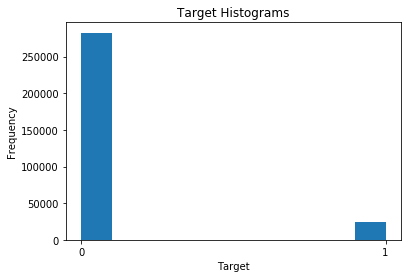

In [51]:
plt.hist(app_train['TARGET'].values)
plt.title('Target Histograms')
plt.xticks(np.arange(0, 1.1, step=1))
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

Imbalanced data set.
There are far more loans that were repaid on time than loans that were not repaid.

### Effect of age on target (applicant has difficulty repay the loan or not)

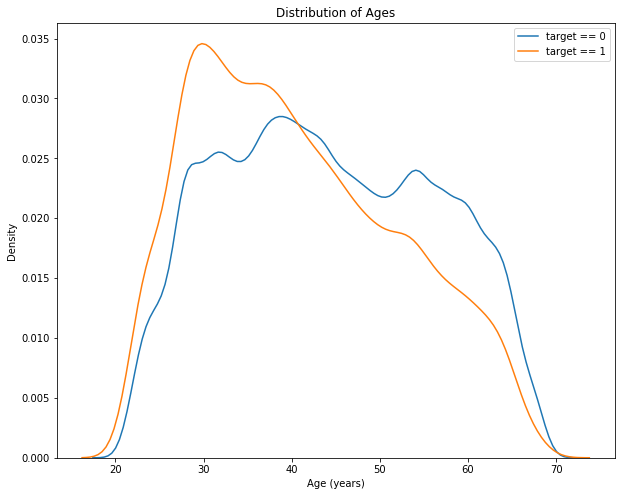

In [25]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.show()

The target == 1 (applicant has difficulty repay the loan) curve skews towards the younger end of the range. 

Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

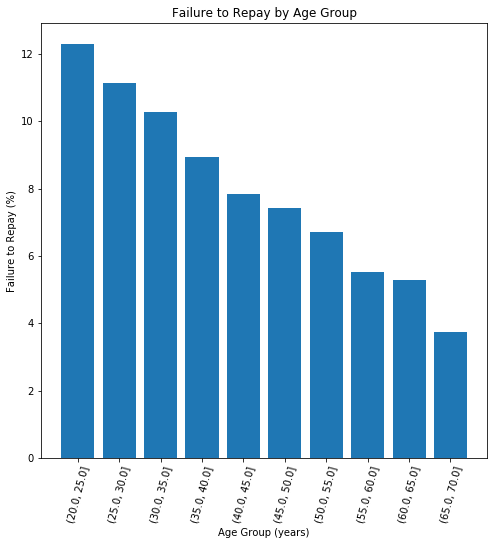

In [26]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')
plt.show()

There is a clear trend: younger applicants are more likely to fail repaying the loan! The rate of failure to repay is above 10% for the youngest three age groups and below 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Effect of days employed on target (applicant has difficulty repay the loan or not)

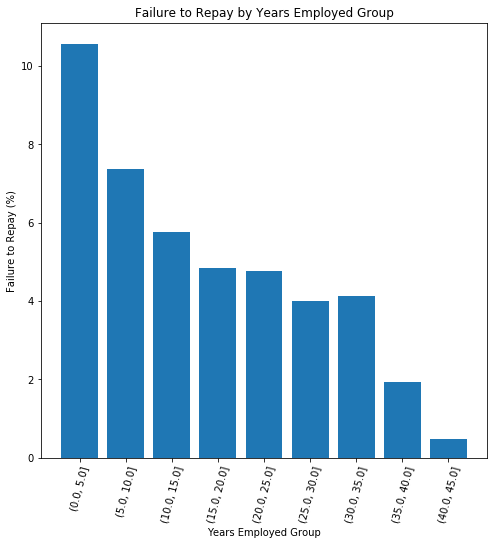

In [47]:
# Days employed information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_EMPLOYED']]
age_data['YEARS_EMPLOYED'] = age_data['DAYS_EMPLOYED'] / 365

# Bin the years employed data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_EMPLOYED'], bins = np.linspace(0, 45, num = 10))
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Years Employed Group')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Years Employed Group')
plt.show()

With more years employed at the time of application, applicants have better chance to repay the loan
With years employed over 10-15 years, failure to repay (%) is below 5%

### Effect of credit amount on target (applicant has difficulty repay the loan or not)

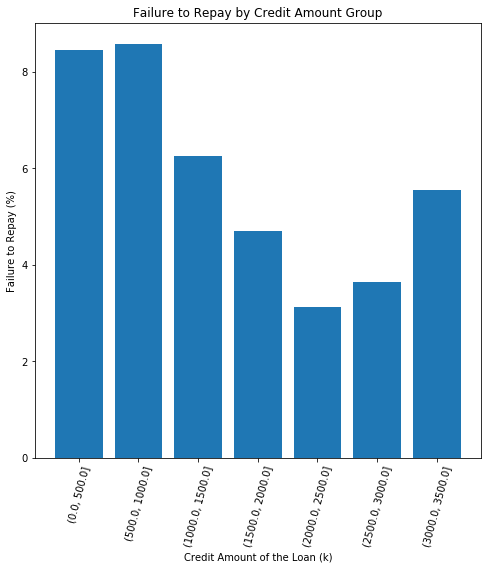

In [50]:
# Credit Amount information into a separate dataframe
age_data = app_train[['TARGET', 'AMT_CREDIT']]

# Bin the credit amount data
age_data['AMT_CREDIT'] = pd.cut(age_data['AMT_CREDIT']/1000, bins = np.linspace(0, 3500, num = 8))
# Group by the bin and calculate averages
age_groups  = age_data.groupby('AMT_CREDIT').mean()

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Credit Amount of the Loan (K)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Credit Amount Group')
plt.show()

Overall, larger credit amount of loan has more likely to be repaid
However, loan of credit amount over 2,500K is more likely to be failed repaid

# 3. Feature Engineering

We first develope functions to tranform and abstract features from tabels that are not train dataset. Then, after applying functions to these tables, we merge these features with train dataset. In this step, we have 1,349 features in train dataset. Since the number of features is significantlt large, we select features according to three criteria. In the end, we have 536 features left.

## 3.1 Abstract Features

We use different approaches to deal with categorical or numeric variables, respectively. For numeric variables, we would group by id, and then calculate aggregation statistics including min, max, mean, sum. For categorical variables, we can calculate count, norm_count instead. Then we would merge these feature back to the train data set by using id 'SK_ID_CURR'.

In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [60]:
# Read in new copies of all the dataframes
train = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/application_train.csv')
bureau = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/bureau.csv')
bureau_balance = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/bureau_balance.csv')
test = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/application_test.csv')

### 3.1.1 Create Functions for Feature Enginnering

In this part, we create 6 functions to deal with categorical and numeric variables in different tables. We first create two functions to handle categorical and numeric variables in bureau.csv and bureau_balance.csv. Then we develope three functions to cope with previous_application.csv. Besides, we have one function to deal with the other tables.

This function, agg_numeric0, is used to handel the numeric aggregations for bureau.csv and bureau_balance.csv.

In [62]:
def agg_numeric0(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

This function, count_categorical, is used to handle categorical variables for bureau.csv and bureau_balance.csv.

In [63]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

This function, agg_categorical, is used to transform categorical variables for previous_application.csv.

In [64]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

This function, convert_types, is used for transforming datatype for previous_application.csv.

In [65]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)
def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

This function, agg_numeric, is used to aggregate numeric variables for previous_application.csv.

In [67]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

This function, aggregate_client, is used to transform variables for client-level datasets.

In [ ]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

### 3.1.2 Apply Functions to Datasets

### Bureau.csv

Bureau.csv includes information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row. In terms of application.csv, one row represents one loan. So we can merge bureau.csv with application.csv by id, 'SK_ID_CURR'.

In [68]:
# Counts of Bureau Dataframe
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [69]:
# Aggregated Stats of Bureau Dataframe
bureau_agg = agg_numeric0(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Bureau_balance.csv

Bureau_balance.csv contains monthly information about the previous loans. Each month has its own row.

In [70]:
# Value counts of Bureau Balance dataframe by loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [71]:
# Aggregated stats of Bureau Balance dataframe by loan
bureau_balance_agg = agg_numeric0(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [72]:
# Aggregated Stats of Bureau Balance by Client
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric0(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

### Insert features to train dataset

After abstracting feactures from bureau.csv and bureau_balance.csv, we merge these features with the train dataset. There are 122 features in the train dataset(application.csv), and after merging, we have 333 features in the train dataset.

In [73]:
# Insert Computed Features into Training Data
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [74]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [75]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


In [76]:
# Merge test dataset with features we create
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

### Previous_application.csv

In [78]:
previous = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.16 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 80)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,...,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606,-606,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100003,-3915,-2341,-1305.0,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,...,365243.0,365243.0,365243.0,1095729.0,NaN,NaN,NaN,NaN,NaN,NaN
100004,-815,-815,-815.0,-815,-784.0,-784.0,-784.000000,-784.0,-724.0,-724.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100005,-1072,-757,-536.0,-315,-706.0,-706.0,-706.000000,-706.0,-466.0,-466.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


In [81]:
train = convert_types(train)
test = convert_types(test)

# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

In [82]:
# Remove variables to free memory
import gc 
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

153

### POS_CASH_balance.csv

In [83]:
cash = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [84]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28.0,32.0,36.0,36.000000,36.0,41,41,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,456.0,361.0,456.0,456.000000,456.0,361,361,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,288.0,256.0,248.0,283.000000,288.0,272,272,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,16.0,12.0,12.0,15.000000,16.0,16,16,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,132.0,99.0,99.0,128.699997,132.0,110,110,121,792.0,1287.0


In [85]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 165)


21

### credit_card_balance.csv

In [86]:
credit = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [87]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432373,4843.063965,4843.063965,4843.063965,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346191,7168.346191,7168.346191,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 381)


21

### installments_payments.csv

In [89]:
installments = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/installments_payments.csv')
installments = convert_types(installments, print_info = True)
installments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.44 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [90]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


In [91]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 106)


14

### In the end...

After merging with all datasets, we get our final train dataset with 1,349 features. We save these datasets so that we can use them in the next step, feature selection.

In [92]:
train.shape

(307511, 1350)

In [93]:
test.shape

(48744, 1349)

In [94]:
# Save train and test dataset
train.to_csv('train_previous_raw.csv', index = False, chunksize = 500)
test.to_csv('test_previous_raw.csv', index = False)

## 3.2 Feature Selection

After abstracting features from these tables, we have 1,349 features in total, which is prtty large. So we use feature selection to reduce features. We have three criteria to select features:

- delete columns whose percentage of missing values is greater than 75%
- delete one of two features whose correlation is greater than 0.9
- delete features whose importance score is 0

In [2]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

import sys
import gc 

plt.style.use('fivethirtyeight')

In [3]:
# read in the dataset from feature engineering
train = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/train_previous_raw.csv')
test = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/test_previous_raw.csv')

### 3.2.1. Percentage of Missing Values > 75%

This function is created to calculate the number of missing values in each column and the percentage of missing values accounting for each column.

In [4]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

This function is defined to remove the columns whose percentage of missing value is greater than the threshold.

In [5]:
def remove_missing_columns(train, test, threshold = 75):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

We can see that some columns contain high percentage of missing values. We decide to delete those columns that have a percentage of missing values greater than 75%. Then we delete 69 columns and there are still 1,281 features in our dataset.

In [6]:
missing_train = missing_values_table(train)
missing_train.head(10)

,Missing Values,% of Total Values
previous_RATE_INTEREST_PRIVILEGED_max,302902,98.5
previous_RATE_INTEREST_PRIVILEGED_mean,302902,98.5
previous_RATE_INTEREST_PRIVILEGED_min,302902,98.5
previous_RATE_INTEREST_PRIMARY_max,302902,98.5
previous_RATE_INTEREST_PRIMARY_mean,302902,98.5
previous_RATE_INTEREST_PRIMARY_min,302902,98.5
client_credit_AMT_PAYMENT_CURRENT_mean_max,246451,80.1
client_credit_AMT_PAYMENT_CURRENT_min_max,246451,80.1
client_credit_AMT_PAYMENT_CURRENT_min_mean,246451,80.1
client_credit_AMT_PAYMENT_CURRENT_min_min,246451,80.1


In [7]:
train, test = remove_missing_columns(train, test)

There are 69 columns with greater than 75% missing values.


In [8]:
train.shape

(307511, 1281)

In [9]:
test.shape

(48744, 1280)

### 3.2.2 Remove columns created by id

Features that are created by id shoud be deleted since it has no meaning. Here one column in train dataset is deleted.

In [10]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

There are 1 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
Training shape:  (307511, 1280)
Testing shape:  (48744, 1279)


### 3.2.3 One hot encoding

We perform one hot encoding to transform categorical features, and then the number of features increases to 1,400.

In [10]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 1400)
Testing shape:  (48744, 1400)


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 1400 entries, CNT_CHILDREN to EMERGENCYSTATE_MODE_Yes
dtypes: bool(5), float64(1224), int64(34), uint8(137)
memory usage: 2.9 GB


### 3.2.4 Remove Collinear Variables

Here we calculate the correlation between features and then delete one of the pairs whose correlation is greater than 0.9. After that, we delete 562 features and there are 838 features left. 

In [12]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,0.028019,...,0.001830,0.005272,0.000709,0.001607,0.002032,0.020892,0.025088,0.011036,0.038644,0.004525
AMT_INCOME_TOTAL,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,0.008506,...,0.000718,0.011696,0.006149,0.023886,0.003886,0.032753,0.016523,0.003369,0.050174,0.002894
AMT_CREDIT,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,0.006575,...,0.000869,0.014314,0.007987,0.027255,0.005799,0.046644,0.009756,0.007373,0.058256,0.004308
AMT_ANNUITY,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,0.104332,0.038514,0.011268,...,0.002166,0.015589,0.010077,0.035318,0.005968,0.054988,0.009189,0.007711,0.068145,0.003910
AMT_GOODS_PRICE,0.001827,0.159610,0.986968,0.775109,1.000000,0.103520,0.053442,0.064842,0.011565,0.009267,...,0.000796,0.013696,0.009955,0.028315,0.005877,0.049759,0.012888,0.009135,0.062878,0.004848


In [13]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,0.028019,...,0.001830,0.005272,0.000709,0.001607,0.002032,0.020892,0.025088,0.011036,0.038644,0.004525
AMT_INCOME_TOTAL,NaN,NaN,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,0.008506,...,0.000718,0.011696,0.006149,0.023886,0.003886,0.032753,0.016523,0.003369,0.050174,0.002894
AMT_CREDIT,NaN,NaN,NaN,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,0.006575,...,0.000869,0.014314,0.007987,0.027255,0.005799,0.046644,0.009756,0.007373,0.058256,0.004308
AMT_ANNUITY,NaN,NaN,NaN,NaN,0.775109,0.118429,0.009445,0.104332,0.038514,0.011268,...,0.002166,0.015589,0.010077,0.035318,0.005968,0.054988,0.009189,0.007711,0.068145,0.003910
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,NaN,0.103520,0.053442,0.064842,0.011565,0.009267,...,0.000796,0.013696,0.009955,0.028315,0.005877,0.049759,0.012888,0.009135,0.062878,0.004848


In [14]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 562 columns to remove.


In [15]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 838)
Testing shape:  (48744, 838)


In [42]:
# take the target and id out
train_ = pd.read_csv('/Users/liuya/Documents/GWU DS/ML1_Huang/final_project/train_previous_raw.csv')
train_labels = train_["TARGET"]
train_ids = train_['SK_ID_CURR']
# test_ids = test['SK_ID_CURR']

In [45]:
gc.enable()
del train_
gc.collect()

75

### 3.2.5 Feature Selection through Feature Importances

We fit a gradient boosting machine here and then get feature importance. We delete those features that have 0 importance. So we drop 302 features and have 536 features left.

In [37]:
# modeling 
import lightgbm as lgb

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [39]:
# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [47]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.781881	valid_0's binary_logloss: 0.508782
Early stopping, best iteration is:
[158]	valid_0's auc: 0.782124	valid_0's binary_logloss: 0.519101
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.783986	valid_0's binary_logloss: 0.508331
Early stopping, best iteration is:
[138]	valid_0's auc: 0.784514	valid_0's binary_logloss: 0.52404


In [48]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
24,EXT_SOURCE_1,153.0
25,EXT_SOURCE_2,127.5
26,EXT_SOURCE_3,114.0
5,DAYS_BIRTH,87.5
702,client_installments_AMT_PAYMENT_min_sum,82.0


In [49]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 302 features with 0.0 importance


,feature,importance
250,previous_NAME_CASH_LOAN_PURPOSE_Journey_sum,0.0
252,previous_NAME_CASH_LOAN_PURPOSE_Furniture_sum,0.0
253,previous_NAME_GOODS_CATEGORY_Weapon_mean,0.0
254,previous_NAME_GOODS_CATEGORY_Weapon_sum,0.0
837,EMERGENCYSTATE_MODE_Yes,0.0


In [50]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

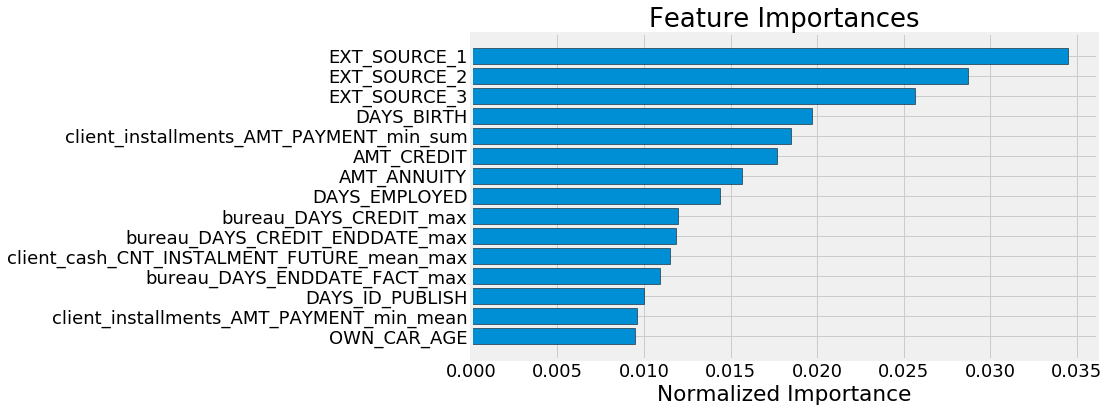

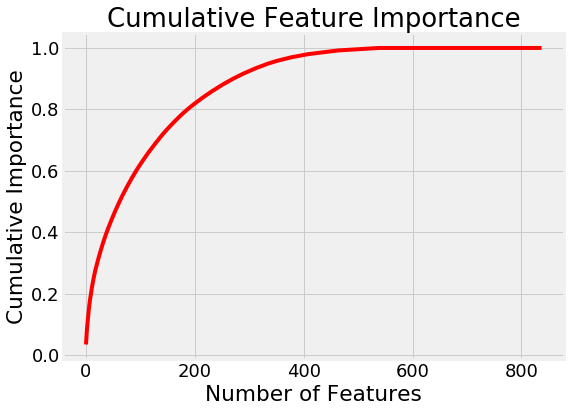

272 features required for 0.90 of cumulative importance


In [51]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [52]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 536)
Testing shape:  (48744, 536)


In [54]:
# save train, test, and labels
train.to_csv('train_previous_raw1.csv', index = False, chunksize = 500)
test.to_csv('test_previous_raw1.csv', index = False)
train_labels.to_csv('train_labels.csv', index = False)

## 4. Model Development

### 4.1 Data Preprocessing

Now, we have a new dataset with more features. To fit the model, we should get the data prepared. 

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

import sys
import gc 

plt.style.use('fivethirtyeight')

#### Load data

In [2]:
train = pd.read_csv('../final_project/train_previous_raw1.csv')
test = pd.read_csv('../final_project/test_previous_raw1.csv')
app_train = pd.read_csv('../final_project/application_train.csv')
app_test = pd.read_csv('../final_project/application_test.csv')

#### Impute missing values with mean 

In [10]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

#### Get features and target

In [11]:
X = train
y = app_train['TARGET']

### 4.2 Hyperparameter tuning

Because of the large dataset, this part may be very time-consuming. Here, I choose only 1% of the whole dataset to do hyperparameter tuning.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test=train_test_split(X,y,test_size=0.01,random_state=0, stratify=y)
X1 = X_test
y1 = y_test

Here, (X1,y1) is the randomly chosen subset to do the hyperparameter tuning. 

In [13]:
pd.DataFrame(data=y1, columns=['TARGET'])['TARGET'].value_counts()

0    2828
1     248
Name: TARGET, dtype: int64

#### Oversampling 

Because the data is imbalanced, we should do oversampling before hyperparamter tuning. 

In [14]:
from imblearn.over_sampling import RandomOverSampler

# RandomOverSampler (with random_state=0)
ros = RandomOverSampler(random_state=0)
X1, y1 = ros.fit_sample(X1,y1)

pd.DataFrame(data=y1, columns=['TARGET'])['TARGET'].value_counts()

1    2828
0    2828
Name: TARGET, dtype: int64

#### Create dictionaries for classifiers 

In this section, we use several classifiers to get the results. 
- In the dictionary:
    - the key is the acronym of the classifier
    - the value is the classifier

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

clfs = {'lr': LogisticRegression(random_state=0),
        'mlp': MLPClassifier(random_state=0),
        'dt': DecisionTreeClassifier(random_state=0),
        'rf': RandomForestClassifier(random_state=0),
        'xgb': XGBClassifier(seed=0),
        }

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), 
                                ('clf', clf)])

In [17]:
param_grids = {}

C_range = [10 ** i for i in range(-4, 5)]

param_grid = [{'clf__multi_class': ['ovr'], 
               'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'clf__C': C_range},
              
              {'clf__multi_class': ['multinomial'],
               'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'clf__C': C_range}]

param_grids['lr'] = param_grid

In [18]:
param_grid = [{'clf__hidden_layer_sizes': [10, 100],
               'clf__activation': ['identity', 'logistic', 'tanh', 'relu']}]

param_grids['mlp'] = param_grid

In [19]:
param_grid = [{'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['dt'] = param_grid

In [20]:
param_grid = [{'clf__n_estimators': [10, 100],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['rf'] = param_grid

In [21]:
param_grid = [{'clf__eta': [10 ** i for i in range(-4, 1)],
               'clf__gamma': [0, 10, 100],
               'clf__lambda': [10 ** i for i in range(-4, 5)]}]

param_grids['xgb'] = param_grid

Here we use two functions for hyperparameter tuning:
- [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html): Exhaustive search over specified parameter values for an estimator
- [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html): Stratified K-Folds cross-validator

In [22]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

# For each classifier
for name in pipe_clfs.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='accuracy',
                      n_jobs=-1,
                      iid=False,
                      cv=StratifiedKFold(n_splits=2,
                                         shuffle=True,
                                         random_state=0))
    # Fit the pipeline
    gs = gs.fit(X1, y1)
    
    # Update best_score_param_estimators
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

### 4.3 Model selection

In [23]:
# Sort best_score_param_estimators in descending order of the best_score_
# Implement me
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# For each [best_score_, best_params_, best_estimator_]
for best_score_param_estimator in best_score_param_estimators:
    # Print out [best_score_, best_params_, best_estimator_], where best_estimator_ is a pipeline
    # Since we only print out the type of classifier of the pipeline
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[0.9968175388967468, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}, <class 'sklearn.ensemble.forest.RandomForestClassifier'>]

[0.9600424328147101, {'clf__activation': 'relu', 'clf__hidden_layer_sizes': 100}, <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>]

[0.9255657708628006, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}, <class 'sklearn.tree.tree.DecisionTreeClassifier'>]

[0.9034653465346535, {'clf__eta': 0.0001, 'clf__gamma': 0, 'clf__lambda': 0.0001}, <class 'xgboost.sklearn.XGBClassifier'>]

[0.9008132956152759, {'clf__C': 10000, 'clf__multi_class': 'multinomial', 'clf__solver': 'newton-cg'}, <class 'sklearn.linear_model.logistic.LogisticRegression'>]



Here, we can find that the best model is random forest model with these hyperparameters. Next, we will use this model to fit and predict. 

### 4.4 Model fit and prediction 

#### Oversampling

In [24]:
X2, y2 = ros.fit_sample(X,y)   # X2,y2 is the dataset after oversampling the whole dataset. 
pd.DataFrame(data=y2, columns=['TARGET'])['TARGET'].value_counts()

1    282686
0    282686
Name: TARGET, dtype: int64

#### Model fit with the whole data

We only use a small part of the whole training dataset, so we should use the whole dataset to refit the random forest model with these hyperparameters.

In [25]:
rf=best_score_param_estimators[0][2]
rf.fit(X2,y2)

Pipeline(memory=None,
         steps=[('StandardScaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

#### Prediction

In [30]:
y_pred = rf.predict_proba(test)[:,1] # here we use the probability.

In [32]:
# Make a submission dataframe

results = app_test[['SK_ID_CURR']]
results['TARGET'] = y_pred

# Save the submission dataframe
results.to_csv('rf.csv', index = False)

After submitting the results to the kaggle, we can find that the prediction score(AUC_ROC) is 0.72825. 

## 5. Conclusion and Discussion

### 5.1 Feature importance

In [36]:
feature_value_names = X.columns.values

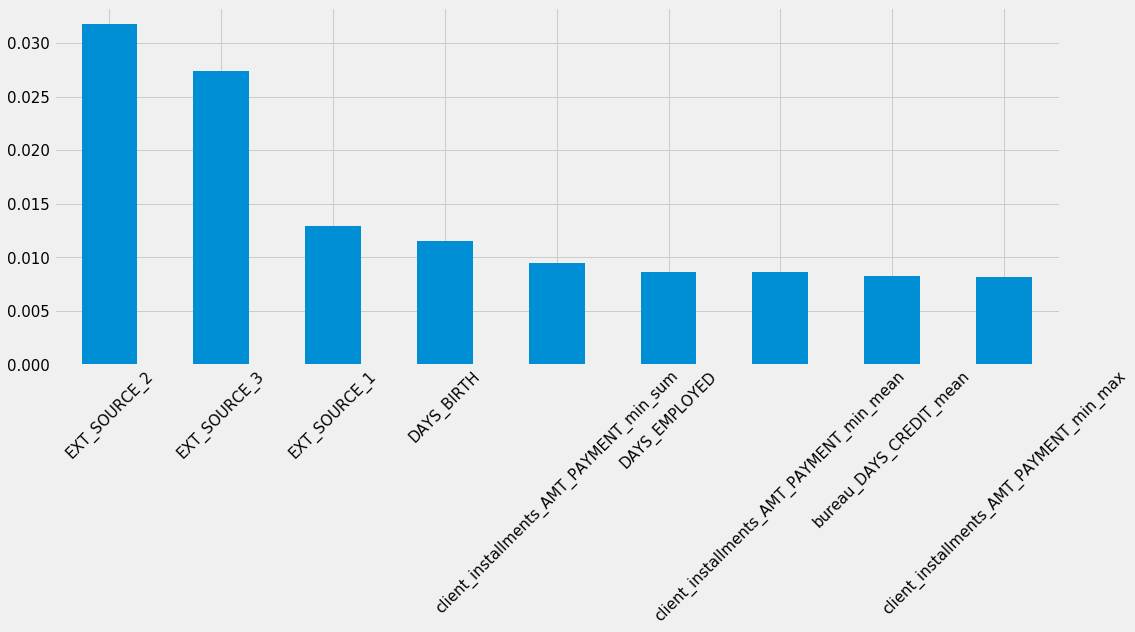

In [35]:
import matplotlib.pyplot as plt

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(rf.named_steps['clf'].feature_importances_, feature_value_names)

# Top 9 the array in descending order of the importances
f_importances = f_importances.sort_values(ascending=False)[0:9]

# Draw the bar Plot from f_importances 
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=15)

# Show the plot
plt.tight_layout()
plt.show()

From this feature importance plot from random forest, the scores from external sources are of great importance. But unfortunately, we don't know what exactly they are. And also clients'age and working time are also significant.  

### 5.2 Disscussion

1. In this project, we use the oversampling method when dealing with the large imbalanced data. But we find it may be not an efficient way because We nearly double this large dataset when fitting the model, which may cost much more time to get the results. Maybe undersampling, class weights or some others ways  can be more efficient. 

2. When doing feature engineering and selection, we have tried the automated feature engineering using the package "featuretools". But it is really time-consuming. So here we choose to do some simple process such as mean for numeric variables, counts for categorical variables. In this part, there is a lot to improve. So in the near future, we want to learn more about feature engineering and selection. 

3. After doing this project, what impresses me most is that efficiency is really important as well as accuracy. It is not easy to balacnce efficiency and accuracy. In this project, when doing hyperparamter tuning, if we use the whole training set after oversampling, it is too big for our PC to handle. We used one night to run but it was not completed. So we have to choose to lose some efficiency to spped up the process. We try to use the subset to do the hyperparameter tuning and model selection. The results seems not bad. And then we refit the model with the whole dataset to get the predictions. To balance efficiency and accuracy, it is a good way to try different ways or change some parameters. We should get more experience dealing with the efficiency and accuracy. 

## 6. Reference

Regards the exploratory data analysis, we refer to the notebook below.
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/

In terms of the feature enginnering, we refer to the notebook below.
https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output